# 第6章: 機械学習
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50. データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このフ
ァイルは後に問題70で再利用する）．
学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [1]:
!wget -nc "https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip" -P data

--2021-06-27 14:58:34--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
archive.ics.uci.edu (archive.ics.uci.edu) をDNSに問いあわせています... 128.195.10.252
archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 29224203 (28M) [application/x-httpd-php]
`data/NewsAggregatorDataset.zip' に保存中

NewsAggregatorDatas 100%[===================>]  27.87M  6.49MB/s 時間 4.8s       

2021-06-27 14:58:40 (5.77 MB/s) - `data/NewsAggregatorDataset.zip' へ保存完了 [29224203/29224203]



In [2]:
!unzip data/NewsAggregatorDataset.zip

Archive:  data/NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [4]:
!wc data/newsCorpora.csv

   422937   7279776 102297000 data/newsCorpora.csv


In [6]:
!head data/readme.txt

SUMMARY: Dataset of references (urls) to news web pages

DESCRIPTION: Dataset of references to news web pages collected from an online aggregator in the period from March 10 to August 10 of 2014. The resources are grouped into clusters that represent pages discussing the same news story. The dataset includes also references to web pages that point (has a link to) one of the news page in the collection.

TAGS: web pages, news, aggregator, classification, clustering

LICENSE: Public domain - Due to restrictions on content and use of the news sources, the corpus is limited to web references (urls) to web pages and does not include any text content. The references have been retrieved from the news aggregator through traditional web browsers. 

FILE ENCODING: UTF-8



In [7]:
# ファイルの読み込み、一部の表示
import random
from zipfile import ZipFile  # zipファイルの処理用モジュール
where = ('ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP')  # 列名
extract_set = {'Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail'}  # 抽出する事例のpublisherリスト
extract_data = []


# 1.ダウンロードしたzipファイルを解凍
with ZipFile('data/NewsAggregatorDataset.zip') as myzip:
    with myzip.open('newsCorpora.csv') as file:
        for line in file:
            _, title, _, publisher, category, *_ = line.decode('utf-8').rstrip('\n').split('\t')  # utf-8でdecode,タブ区切りで分割
            
            # 2.publisherが抽出リストに入っているかどうか判定、入っていればextract_dataに追加
            if publisher in extract_set:
                extract_data.append([title, category])
                
                
# 3.抽出された事例をランダムに並び替える
shuffle_data = random.sample(extract_data, len(extract_data))


# 4.抽出された事例を分割
data_size = len(shuffle_data)
train_data = shuffle_data[:int(data_size * 8) // 10]
valid_data = shuffle_data[int(data_size * 8) // 10:int(data_size * 9) // 10]
test_data = shuffle_data[int(data_size * 9) // 10:]


print('all data size:', data_size)
print('train data size:', len(train_data))
print('valid data size:', len(valid_data))
print('test data size:', len(test_data))

all data size: 13356
train data size: 10684
valid data size: 1336
test data size: 1336


In [8]:
# ファイルに書き込むための関数
def write_file(file_path: str, data: list):
    with open(file_path, "w") as f:
        f.write("\n".join(c + "\t" + t for c, t in data))

In [9]:
write_file('work/train.txt', train_data)
write_file('work/valid.txt', valid_data)
write_file('work/test.txt', test_data)

In [10]:
!cut -f 2 work/train.txt | sort | uniq -c

   4496 b
   4227 e
    738 m
   1223 t


In [11]:
!cut -f 2 work/test.txt | sort | uniq -c

    565 b
    536 e
     84 m
    151 t


# 51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [12]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
def load_file(file_path: str) -> dict:  # train,valid,test dataの読み込み(辞書にして返す)
    with open(file_path) as fi:
        data = {'title':[], 'category':[]}
        for line in fi:
            title, category = line.strip('\n').split('\t')
            data['title'].append(title)
            data['category'].append(category)
    return data


def data_np_saver(filename: str, data: 'numpy.ndarray'):  # データを指定したファイルに書き込む
    np.save(filename,data)  # numpy配列を保存

    
def data_np_loader(filename: str) -> 'numpy.ndarray':  # データを読み込みリストで返す
    return np.load(filename).astype(np.float32)  # numpy配列を読み込み


def char2num(y_data: list) -> 'numpy.ndarray':  # category -> number
    category2num = {'b':0,'t':1,'e':2,'m':3}  # カテゴリを数値で扱う時用
    return np.array([category2num[c] for c in y_data])

In [14]:
# 各種データの読み込み(辞書型)
train_data = load_file('work/train.txt')
valid_data = load_file('work/valid.txt')
test_data = load_file('work/test.txt')

In [15]:
# 特徴量としてtf-idfを使用
vectorizer = TfidfVectorizer(min_df=0.0001)  # 使用されている文章が全体の0.0001%以下の単語を無視
train_tfidf = vectorizer.fit_transform(train_data['title'])  # train dataのタイトルを使ってtf-idfを計算
words = vectorizer.get_feature_names()  # 語彙を取得
print('vocab size:', len(words))

vocab size: 7568


In [16]:
valid_tfidf = vectorizer.transform(valid_data['title'])  # valid dataをtf-idf行列に変換
test_tfidf = vectorizer.transform(test_data['title'])  # test dataをtf-idf行列に変換

# 特徴量の保存
data_np_saver('work/train.feature', train_tfidf.toarray())
data_np_saver('work/valid.feature', valid_tfidf.toarray())
data_np_saver('work/test.feature', test_tfidf.toarray())

In [19]:
# 次元を確認してみる
test_tfidf.shape

(1336, 7568)

In [20]:
# 保存してあった各種データのnumpy配列を読み込み ＆ カテゴリ文字列を数値に変換
x_train = data_np_loader('work/train.feature.npy')
y_train = char2num(train_data['category'])
x_valid = data_np_loader('work/valid.feature.npy')
y_valid = char2num(valid_data['category'])
x_test = data_np_loader('work/test.feature.npy')
y_test = char2num(test_data['category'])

In [21]:
# 中身をみてみる
x_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.31634274, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

## 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [22]:
%%time
from sklearn.linear_model import LogisticRegression
# max_iter:最適解探索の際の最大探索回数, solver:最適解の探索手法, multi_class:2値分類or多値分類
#lr = LogisticRegression(max_iter=1000,solver='lbfgs',multi_class='auto')
lr = LogisticRegression(C=2000, multi_class='auto')
lr.fit(x_train, y_train)

/Users/y_kishinami/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 810 ms, sys: 318 ms, total: 1.13 s
Wall time: 1.55 s


LogisticRegression(C=2000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [24]:
import pandas as pd

In [27]:
# 入力から、予測したカテゴリとその予測確率を返す関数
def predict(inputs: 'numpy.ndarray') -> 'numpy.ndarray, numpy.ndarray':
    output = lr.predict_proba(inputs)
    return output.argmax(axis=1), output.max(axis=1)

In [28]:
category, prob = predict(x_train)
pd.DataFrame(zip(y_train, category, prob), columns=["GOLD", "PRED", "PROB"])

,GOLD,PRED,PROB
0,2,2,1.000000
1,2,2,1.000000
2,0,0,1.000000
3,0,0,1.000000
4,2,2,0.999999
...,...,...,...
10679,2,2,1.000000
10680,3,3,0.999907
10681,0,0,0.999998
10682,0,0,1.000000


## 54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [30]:
# 正解率を計算する関数
def accuracy(lr, x, y):
    pred = lr.predict_log_proba(x).argmax(axis=1)
    return np.mean([p == y for p,y in zip(pred, y)])

In [32]:
print('train accuracy :', accuracy(lr, x_train, y_train))
print('test accuracy :', accuracy(lr, x_test, y_test))

train accuracy : 0.9997192062897791
test accuracy : 0.9258982035928144


#### 1回目：tf-idfを特徴量　max_df=0.005 語彙数10708で実行　solver='liblinear', multi_class='ovr'
- 学習データの正解率：0.7662921348314606
- 評価データの正解率：0.6404494382022472

#### 2回目：tf-idfを特徴量　max_df=0.9 語彙数13990で実行　solver='liblinear', multi_class='ovr'
- 学習データの正解率：0.9172284644194757
- 評価データの正解率：0.8928838951310861

#### 3回目：tf-idfを特徴量　max_df=0.9 語彙数13990で実行　solver='lbfgs',multi_class='auto'
- 学習データの正解率：0.9449438202247191
- 評価データの正解率：0.9071161048689138

#### now :tf-idfを特徴量　min_df=0.0001 語彙数7571で実行　C=2000, multi_class='auto'
- 学習データの正解率：0.9992512167727443
- 評価データの正解率：0.9184131736526946

## 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
# 混同行列を計算する関数
def make_confusion_matrix(x: 'numpy.ndarray', y: 'numpy.ndarray') -> 'numpy.ndarray':
    pred = lr.predict_proba(x).argmax(axis=1)  # 予測カテゴリの配列を取得
    cm = confusion_matrix(y, pred)  # 混同行列を計算
    return cm

In [35]:
train_cm = make_confusion_matrix(x_train, y_train)
print('confusion matrix of train data:', train_cm, sep='\n')

confusion matrix of train data:
[[4495    1    0    0]
 [   2 1221    0    0]
 [   0    0 4227    0]
 [   0    0    0  738]]


In [38]:
test_cm = make_confusion_matrix(x_test,y_test)
print('confusion matrix of test data:', test_cm, sep='\n')

confusion matrix of test data:
[[532  16  14   3]
 [ 15 122   7   7]
 [  8   4 518   6]
 [ 10   3   6  65]]


(4, 0)

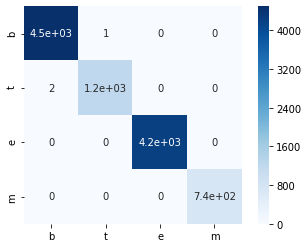

In [39]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

categories = ['b','t','e','m']  # categoryのリスト

# 混同行列の可視化  cmap:色指定　annot:数値を表示するかどうか　square:正方形で表示するかどうか
sns.heatmap(train_cm, annot=True, cmap='Blues', square=True, xticklabels=categories, yticklabels=categories)
plt.ylim(len(train_cm), 0)

(4, 0)

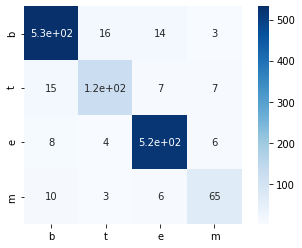

In [40]:
sns.heatmap(test_cm, annot=True, cmap='Blues',square=True, xticklabels=categories, yticklabels=categories)
plt.ylim(len(test_cm), 0)

## 56. 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [41]:
tp = test_cm.diagonal()  # True Positive:猫を猫と予測できてる (confusion matrixの対角成分を抽出)
fp = test_cm.sum(axis=0) - tp  # False Positive:猫じゃないものを猫と予測してる (confusion matrixの列ごとの和からtpを引いたもの)
fn = test_cm.sum(axis=1) - tp  # False Negative:猫を猫じゃないものと予測してる (confusion matrixの行ごとの和からtpを引いたもの)

print('confusion matrix of test data', test_cm, sep='\n')
print('true positive(tp):', tp)
print('false positive(fp):', fp)
print('false negative(fn):', fn)

# 適合率
precision = tp / (tp + fp)  # 選んだもののうち本当に猫だった数/猫と選んだ数
# 再現率
recall = tp / (tp + fn)  # 選んだもののうち猫だった数/猫の数
# F1スコア(適合率と再現率の調和平均)
f1_score = 2 * precision * recall / (precision + recall)

# マイクロ平均　全部まとめて計算しちゃう
micro_p = tp.sum() / (tp.sum() + fp.sum())
micro_r = tp.sum() / (tp.sum() + fn.sum())
micro_f1 = 2 * micro_p * micro_r / (micro_p + micro_r)
# マクロ平均　それぞれを計算してから平均
macro_p = precision.mean()
macro_r = recall.mean()
macro_f1 = 2 * macro_p * macro_r / (macro_p + macro_r)

confusion matrix of test data
[[532  16  14   3]
 [ 15 122   7   7]
 [  8   4 518   6]
 [ 10   3   6  65]]
true positive(tp): [532 122 518  65]
false positive(fp): [33 23 27 16]
false negative(fn): [33 29 18 19]


In [42]:
scores = ['precison', 'recall', 'f1_score']  # 評価値の名前
t = np.array([precision, recall, f1_score])
pd.DataFrame(t, index=scores, columns=categories)

,b,t,e,m
precison,0.941593,0.841379,0.950459,0.802469
recall,0.941593,0.807947,0.966418,0.773810
f1_score,0.941593,0.824324,0.958372,0.787879


In [43]:
ave_name = ['micro-ave', 'macro-ave']
m = np.array([[micro_p, micro_r, micro_f1], [macro_p, macro_r, macro_f1]])
pd.DataFrame(m, index=ave_name, columns=scores)

,precison,recall,f1_score
micro-ave,0.925898,0.925898,0.925898
macro-ave,0.883975,0.872442,0.878171


## 57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [49]:
# 重みの形状の確認
print(lr.coef_.shape)

(4, 7568)


In [45]:
# 上位もしくは下位n個の重みと特徴量をdfで表示する関数
def weight_top_n(x: '-1 or 1', n: int):
    for i in range(len(categories)):
        sorted_w = np.argsort(x*lr.coef_[i])[:n]  # x == 1なら昇順　x == -1なら降順ソート
        weight_n_words = []
        
        for j in sorted_w:
            weight_n_words.append(words[j])  # 対応する単語をリストに追加
        w_df = pd.DataFrame([weight_n_words, lr.coef_[i][sorted_w]], index=['features', 'weights'], columns=np.arange(n)+1)
        
        if x == -1:
            print(categories[i] + ' top ' + str(n))
        elif x == 1:
            print(categories[i] + ' worst' + str(n))

        display(w_df)  # 表示

In [47]:
# 重みの高い特徴量トップ１０
weight_top_n(-1, 10)

b top 10


,1,2,3,4,5,6,7,8,9,10
features,bank,fed,ecb,protection,fitch,dollar,obamacare,lobster,bnp,valued
weights,23.65,23.6074,22.4948,22.0555,20.7889,20.7651,20.0657,19.1293,19.0685,18.9991


t top 10


,1,2,3,4,5,6,7,8,9,10
features,activision,facebook,apple,google,climate,microsoft,heartbleed,tesla,nintendo,nasa
weights,34.1973,32.4468,29.9483,29.8758,27.5272,25.9296,24.2629,22.8307,22.037,21.5552


e top 10


,1,2,3,4,5,6,7,8,9,10
features,transformers,chris,thrones,hbo,music,courtney,trailer,kardashian,bossy,harris
weights,19.9341,19.7049,19.1146,18.3165,18.1593,17.8063,17.444,17.047,16.3549,16.2298


m top 10


,1,2,3,4,5,6,7,8,9,10
features,ebola,fda,mers,cancer,cigarettes,doctors,abortion,study,expectancy,cases
weights,27.2121,24.3339,19.831,19.7783,19.4973,18.9242,17.8551,17.3484,17.2221,16.9455


In [48]:
# 重みの低い特徴量トップ１０
weight_top_n(1, 10)

b worst10


,1,2,3,4,5,6,7,8,9,10
features,activision,courtney,gnip,facebook,researchers,twitch,ebola,nintendo,nfl,aereo
weights,-35.0279,-24.7448,-20.428,-18.7495,-18.6791,-18.5944,-18.5728,-18.2581,-18.0672,-17.2216


t worst10


,1,2,3,4,5,6,7,8,9,10
features,stocks,protection,move,dollar,response,upholds,board,acquisition,thrones,ecb
weights,-20.2237,-18.9122,-18.4885,-17.4868,-17.4733,-16.4122,-16.3135,-16.0122,-15.6936,-15.6145


e worst10


,1,2,3,4,5,6,7,8,9,10
features,google,apple,microsoft,facebook,advert,finished,ceo,risk,update,brain
weights,-21.4502,-20.5737,-19.0927,-19.0021,-17.9242,-17.8448,-16.7229,-15.2786,-14.8906,-14.491


m worst10


,1,2,3,4,5,6,7,8,9,10
features,facebook,google,computer,gm,apple,explain,fed,billion,term,fracking
weights,-14.2021,-13.2544,-10.8582,-10.6075,-10.4369,-10.3131,-10.0467,-9.9835,-9.96938,-9.67482


## 58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [20]:
from tqdm import tqdm
# 正則化パラメータ
C_list = np.arange(0.1,5.1,0.1)
acc_list = []

# 各パラメータで学習
for c in tqdm(C_list):
    lr = LogisticRegression(C=c, solver='lbfgs', multi_class='auto', max_iter=1000)
    lr.fit(x_train, y_train)
    acc_list.append([accuracy(lr, x, y) for x,y in [(x_train, y_train), (x_valid, y_valid), (x_test, y_test)]])


100%|██████████| 50/50 [27:06<00:00, 32.54s/it]


In [21]:
# acc_list 100(iteration回数) * 3(train, valid, test)
print(np.array(acc_list).shape)

(50, 3)


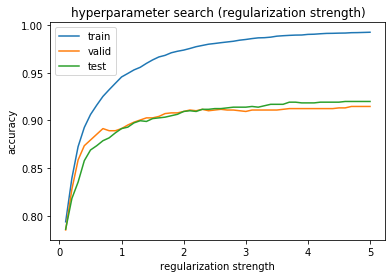

In [22]:
train_acc_list, valid_acc_list, test_acc_list = np.array(acc_list).T  # それぞれのdataでの正解率リストを作成
plt.plot(C_list, train_acc_list, label='train')
plt.plot(C_list, valid_acc_list, label='valid')
plt.plot(C_list, test_acc_list, label='test')
plt.legend()
plt.title('hyperparameter search (regularization strength)')
plt.xlabel('regularization strength')
plt.ylabel('accuracy')
plt.show()  # グラフで表示

## 59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [11]:
def model_accuracy(model, x, y):
    pred = model.predict(x)
    return np.mean([p == y for p, y in zip(pred,y)])

In [24]:
# ナイーブベイズ分類器
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB().fit(x_train, y_train)

In [27]:
# ナイーブベイズ分類器だと性能があまり上がらない
train_acc = model_accuracy(nb, x_train, y_train)
print('train accuracy :', train_acc)
test_acc = model_accuracy(nb, x_test, y_test)
print('test accuracy :', test_acc)

train accuracy : 0.899569449644328
test accuracy : 0.8622754491017964


In [31]:
# サポートベクターマシンでやってみる
from sklearn.svm import LinearSVC
svc_c_list = np.arange(0.1, 10.1, 0.1)
result = dict()  # key:正則化パラメータ　value:検証データの正解率

# 正則化パラメータを探索
for c in svc_c_list:
    svc = LinearSVC(C=c).fit(x_train, y_train)
    result[c] = model_accuracy(svc, x_valid, y_valid)

In [32]:
# validのaccuracyが最大になる時のaccuracy・正則化パラメータの値を確認
print(max(result.values()))
print(max(result, key=result.get))

0.9221556886227545
1.6


In [40]:
from logzero import logger
# logistic regression
lr_c_list = np.arange(0.1, 5.1, 0.1)

logistic_result = dict()
logger.info('hyperparameter search start')

for c in lr_c_list:
    logger.info('training start C:{}'.format(c))
    lr = LogisticRegression(C=c, solver='lbfgs', multi_class='auto', max_iter=1000).fit(x_train,y_train)
    logistic_result[c] = accuracy(lr, x_valid, y_valid)
    logger.info('training done valid accuracy:{}'.format(logistic_result[c]))
logger.info('hyperparameter search done')

[I 201010 12:32:20 <ipython-input-40-c85a3ae6cf81>:6] hyperparameter search start
[I 201010 12:32:20 <ipython-input-40-c85a3ae6cf81>:9] training start C:0.1
[I 201010 12:32:30 <ipython-input-40-c85a3ae6cf81>:12] training done valid accuracy:0.7851796407185628
[I 201010 12:32:30 <ipython-input-40-c85a3ae6cf81>:9] training start C:0.2
[I 201010 12:32:44 <ipython-input-40-c85a3ae6cf81>:12] training done valid accuracy:0.8278443113772455
[I 201010 12:32:44 <ipython-input-40-c85a3ae6cf81>:9] training start C:0.30000000000000004
[I 201010 12:33:01 <ipython-input-40-c85a3ae6cf81>:12] training done valid accuracy:0.8585329341317365
[I 201010 12:33:01 <ipython-input-40-c85a3ae6cf81>:9] training start C:0.4
[I 201010 12:33:16 <ipython-input-40-c85a3ae6cf81>:12] training done valid accuracy:0.8735029940119761
[I 201010 12:33:16 <ipython-input-40-c85a3ae6cf81>:9] training start C:0.5
[I 201010 12:33:37 <ipython-input-40-c85a3ae6cf81>:12] training done valid accuracy:0.8794910179640718
[I 201010 12

In [41]:
print(max(logistic_result, key=logistic_result.get), ':', max(logistic_result.values()))

4.7 : 0.9146706586826348


In [46]:
# 一番いいパラメータでの評価データのacc lr
lr = LogisticRegression(C=4.7, solver='lbfgs', multi_class='auto', max_iter=1000).fit(x_train, y_train)
print('train accuracy :', model_accuracy(lr, x_train, y_train))
print('valid accuracy :', model_accuracy(lr, x_valid, y_valid))
print('test accuracy :', model_accuracy(lr, x_test, y_test))

train accuracy : 0.9920441782104081
valid accuracy : 0.9146706586826348
test accuracy : 0.9199101796407185


In [26]:
# 一番いいパラメータでの評価データのacc svc
svc = LinearSVC(C=1.6).fit(x_train, y_train)
print('train accuracy :', model_accuracy(svc, x_train, y_train))
print('valid accuracy :', model_accuracy(svc, x_valid, y_valid))
print('test accuracy :', model_accuracy(svc, x_test, y_test))

train accuracy : 0.9969112691875702
valid accuracy : 0.9221556886227545
test accuracy : 0.9199101796407185


In [28]:
svc = LinearSVC(C=1.6, loss='hinge',max_iter=10000).fit(x_train, y_train)
print('train accuracy :', model_accuracy(svc, x_train, y_train))
print('valid accuracy :', model_accuracy(svc, x_valid, y_valid))
print('test accuracy :', model_accuracy(svc, x_test, y_test))

train accuracy : 0.9853987270685136
valid accuracy : 0.9191616766467066
test accuracy : 0.9229041916167665


In [18]:
x_data = np.concatenate([x_train, x_valid])
y_data = np.concatenate([y_train, y_valid])

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
params = {'loss':['hinge', 'squared_hinge'], 'C':[10**i for i in range(-3,4)], 'class_weight':[None, 'balanced']}
gscv = GridSearchCV(LinearSVC(), params, cv=5)
gscv.fit(x_data, y_data)

/Users/y_kishinami/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/y_kishinami/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/y_kishinami/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/y_kishinami/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/y_kishinami/.pyenv/versio

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': [None, 'balanced'],
                         'loss': ['hinge', 'squared_hinge']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [22]:
print(gscv.best_params_)

{'C': 1, 'class_weight': 'balanced', 'loss': 'hinge'}


In [23]:
svc = LinearSVC(C=1, class_weight='balanced', loss='hinge').fit(x_train, y_train)
print('train accuracy :', model_accuracy(svc, x_train, y_train))
print('valid accuracy :', model_accuracy(svc, x_valid, y_valid))
print('test accuracy :', model_accuracy(svc, x_test, y_test))

/Users/y_kishinami/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train accuracy : 0.9798764507675028
valid accuracy : 0.9236526946107785
test accuracy : 0.9146706586826348
